In [1]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
from timm.models.layers.conv2d_same import Conv2dSame
import pickle
import random

import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import dicom 

from monai.transforms import Resize
import monai.transforms as transforms

import SegmentationModel
#import CreateMonaiDataSet

import warnings
warnings.filterwarnings("ignore")

c:\Users\Faranak\Documents\Courses\Thesis\RSNA-2022-cervical-spine-fracture-detection\model\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define required directories**

In [2]:

data_dir = 'D:\RSNA-2022-cervical-spine-fracture-detection'
log_dir = './logs'
model_dir = './models'

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

**Define Transformations for input images to monai's inputs**

In [3]:
img_size = [128,128,128]
# Resize the input image to spatial size
monai_img_size = Resize(img_size)
#translate_range, a sequence of positive floats, is used to generate the n shift parameters
translate_range = [int(x*y) for x,y in zip(img_size, (0.3, 0.3, 0.3))]


transform_train_data = transforms.Compose([
    transforms.RandFlipd(keys=["image","mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(["image","mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image","mask"], translate_range=translate_range, padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest")
])

transform_valid_data = transforms.Compose()

device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data Visualization of Train.csv

In [4]:
df_train = pd.read_csv(os.path.join(data_dir,'train.csv'))
num_patients = df_train["StudyInstanceUID"].unique().size
df_train.head(10)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
7,1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
8,1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1


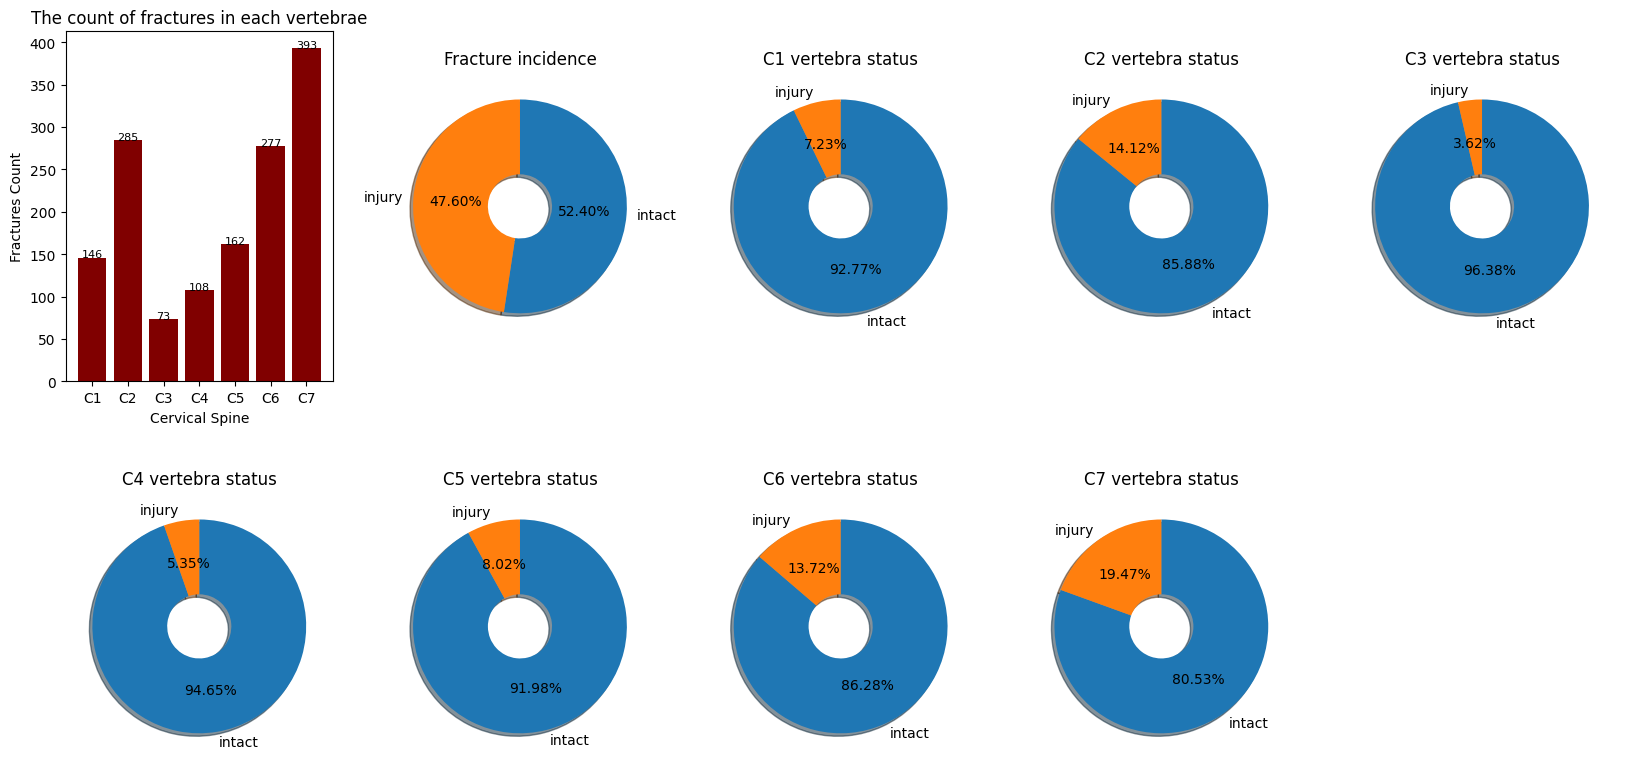

In [5]:
fig = plt.figure(figsize = (20,10))
rows = 2
cols = 5
item = 1

count_fractures = {}
for i in range(7):
    count_fractures[f"C{i+1}"] = df_train.query(f"C{i+1}==1").shape[0]

ax = fig.add_subplot(rows, cols, item)
ax.bar(count_fractures.keys(), count_fractures.values(), color='maroon')
plt.xlabel("Cervical Spine")
plt.ylabel("Fractures Count")
plt.title("The count of fractures in each vertebrae")
for i in range(len(count_fractures)):
    plt.annotate(str(count_fractures[f"C{i+1}"]), xy=(i,count_fractures[f"C{i+1}"]), horizontalalignment="center", fontsize=8)


def plot_pie_chart(data,title):
    global item, fig, rows, cols
    item += 1
    ax = fig.add_subplot(rows, cols, item)
    status = {0:"intact", 1:"injury"}
    ax.pie(data, labels=[status[x] for x in data.index], autopct='%.2f%%', startangle=90, counterclock=False, wedgeprops={'width': 0.7}, shadow = True)
    ax.set_title(title)

patient_overall = df_train["patient_overall"].value_counts()
plot_pie_chart(patient_overall, "Fracture incidence")

c1 = df_train["C1"].value_counts()
plot_pie_chart(c1, "C1 vertebra status")

c2 = df_train["C2"].value_counts()
plot_pie_chart(c2, "C2 vertebra status")

c3 = df_train["C3"].value_counts()
plot_pie_chart(c3, "C3 vertebra status")

c4 = df_train["C4"].value_counts()
plot_pie_chart(c4, "C4 vertebra status")

c5 = df_train["C5"].value_counts()
plot_pie_chart(c5, "C5 vertebra status")

c6 = df_train["C6"].value_counts()
plot_pie_chart(c6, "C6 vertebra status")

c7 = df_train["C7"].value_counts()
plot_pie_chart(c7, "C7 vertebra status")

plt.savefig("assets/train_csv_visualization.png")

# Data Visualization of train_bounding_boxes.csv

In [6]:
df_bbox = pd.read_csv(os.path.join(data_dir,'train_bounding_boxes.csv'))
print("\nThe number of Study Instances that contain bounding boxes",df_bbox["StudyInstanceUID"].nunique())
#Calculate the coordinate of bounding boxes
df_bbox['x'] = df_bbox['x'].apply(lambda x:int(x))
df_bbox['y'] = df_bbox['y'].apply(lambda x: int(x))
df_bbox['x2'] = (df_bbox['x'] + df_bbox['width']).apply(lambda x: int(x))
df_bbox['y2'] = (df_bbox['y'] + df_bbox['height']).apply(lambda x: int(x))
df_bbox.head(10)


The number of Study Instances that contain bounding boxes 235


,StudyInstanceUID,x,y,width,height,slice_number,x2,y2
0,1.2.826.0.1.3680043.10051,219,216,17.30440,20.38517,133,236,236
1,1.2.826.0.1.3680043.10051,221,216,17.87844,25.24362,134,238,241
2,1.2.826.0.1.3680043.10051,216,221,27.00959,26.37454,135,243,247
3,1.2.826.0.1.3680043.10051,214,215,27.92726,37.51363,136,241,252
4,1.2.826.0.1.3680043.10051,214,215,27.00000,43.51363,137,241,258
5,1.2.826.0.1.3680043.10051,213,216,25.13455,47.92717,138,238,263
6,1.2.826.0.1.3680043.10051,209,214,36.06131,51.56834,139,245,265
7,1.2.826.0.1.3680043.10051,204,212,47.47636,57.71635,140,251,269
8,1.2.826.0.1.3680043.10051,205,213,45.00000,59.12658,141,250,272
9,1.2.826.0.1.3680043.10051,205,214,42.89892,63.43364,142,247,277


# Data Visualization of train images (DICOM files)

In [7]:
dicoms_path = os.path.join(data_dir,'train_images')
ds_patients_dicom = glob(f"{dicoms_path}/*")
print(f"Count of patients: {len(ds_patients_dicom)}")

sample_patient_UID = '1.2.826.0.1.3680043.10051'
patient_dicom_paths = glob(f"{dicoms_path}/{sample_patient_UID}/*")

print("Each DICOM file contains these important fileds ImageOrientationPatient,ImagePositionPatient,PatientID,PatientName\n")
print(dicom.load_dicom_meta(patient_dicom_paths[0]))


Count of patients: 2019
Each DICOM file contains these important fileds ImageOrientationPatient,ImagePositionPatient,PatientID,PatientName

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10051.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10051.1.1
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183713.701337'
(0010, 0010) Patient's Name                      PN: '10051'
(0010, 0020) Patient ID                       

**Plot bounding box around dicom image for train dataset**

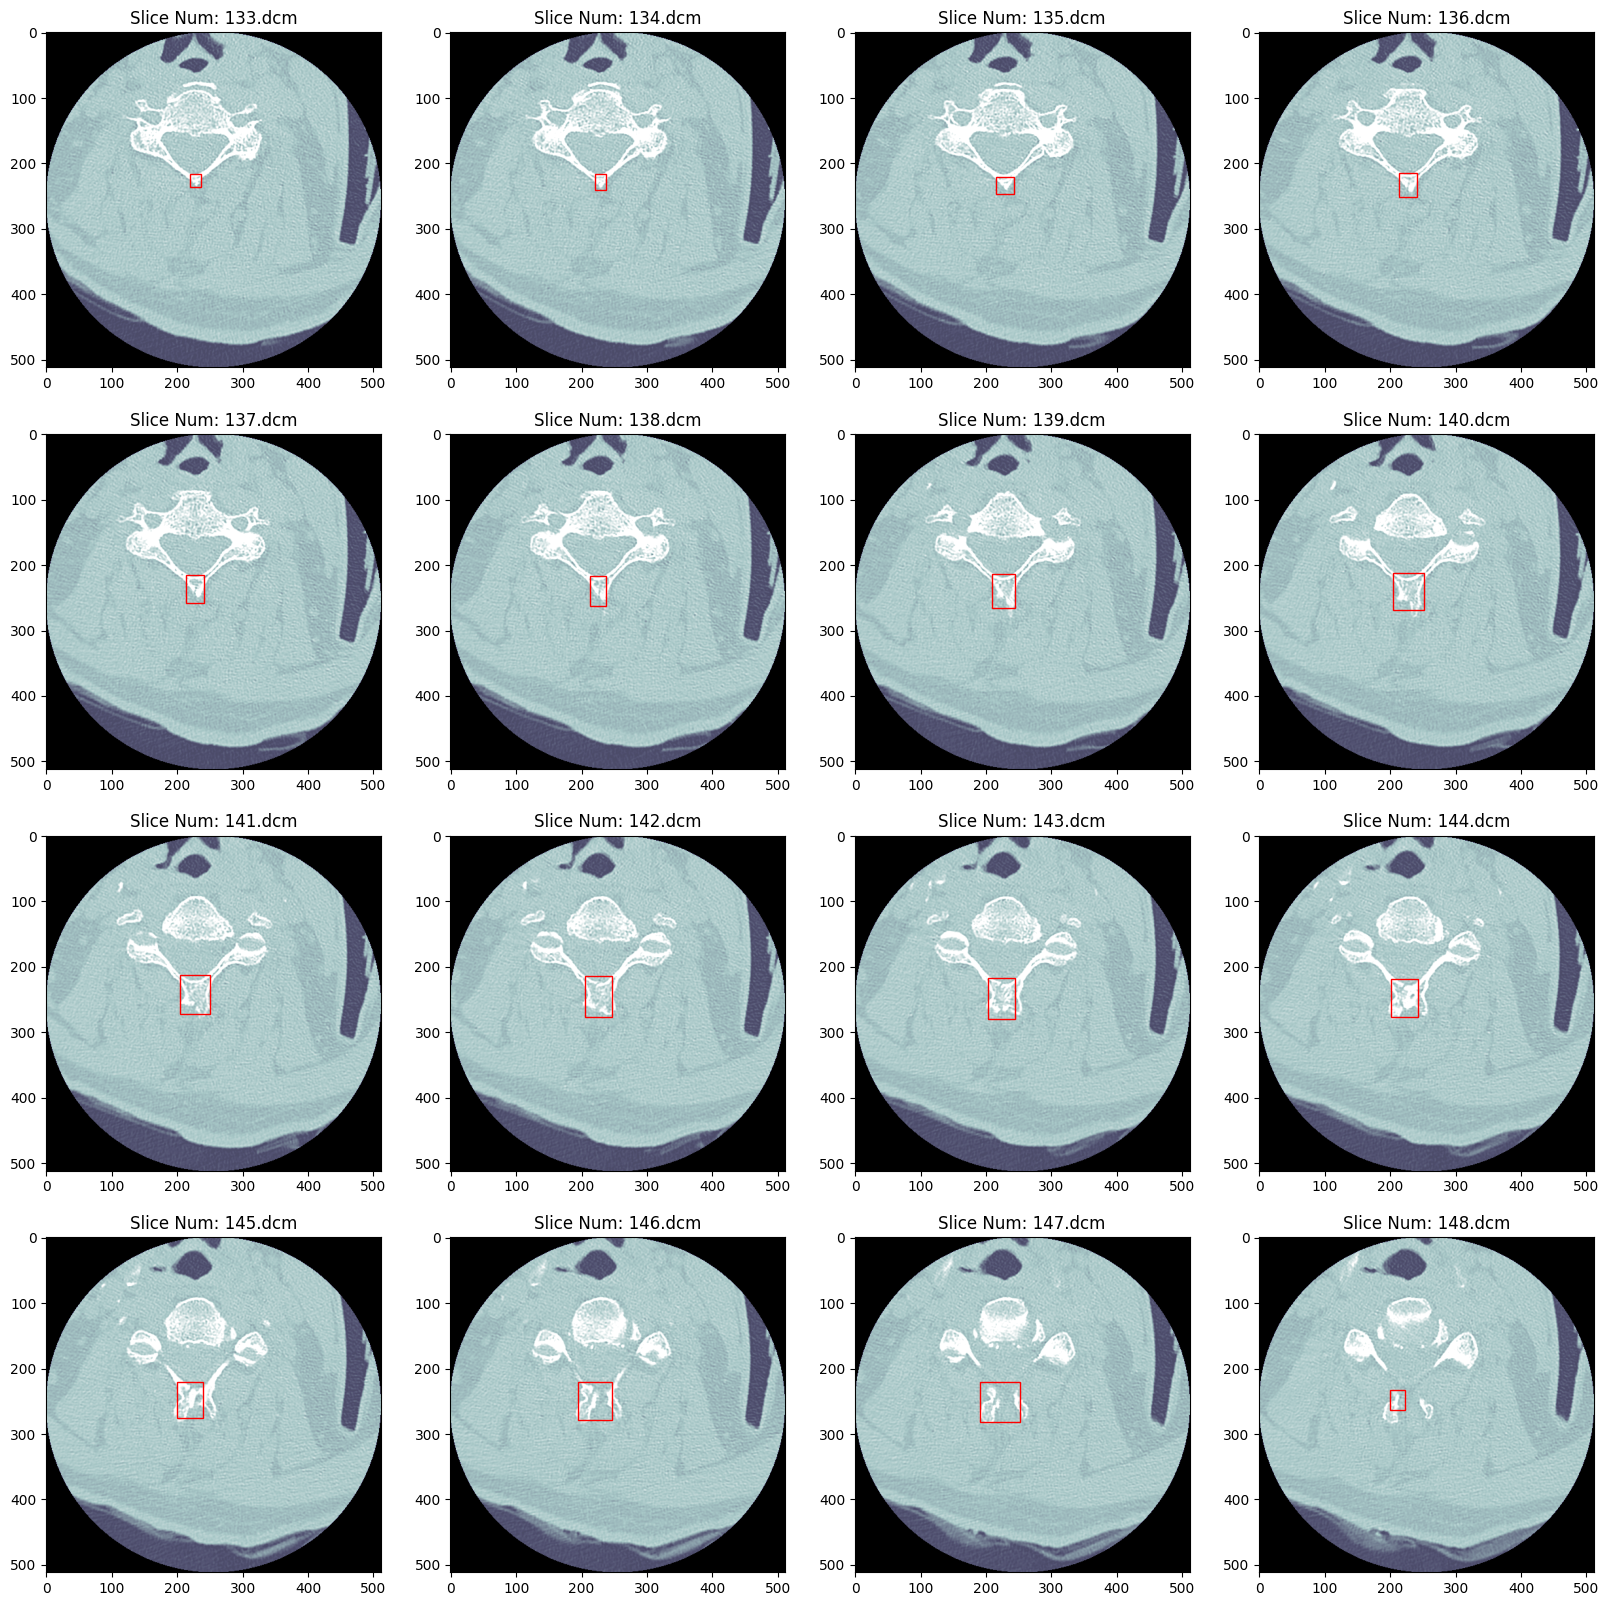

In [19]:
fig = plt.figure(figsize=(20,20))
num_figs = df_bbox.loc[df_bbox['StudyInstanceUID']==sample_patient_UID].shape[0]
rows = num_figs // 4
cols = 4
item = 1

for path in patient_dicom_paths:
    slice_num = path.split("\\")[-1].split(".")[0]
    df_selected_row = df_bbox.loc[(df_bbox['StudyInstanceUID']==sample_patient_UID) & (df_bbox['slice_number']==int(slice_num))]
    
    if (not df_selected_row.empty):
        ax  = fig.add_subplot(rows,cols, item)
        path = os.path.join(data_dir,'train_images',sample_patient_UID, slice_num) + '.dcm'
        img = dicom.load_dicom_VOI(path)
        pt1 = (int(df_selected_row['x'].values),int(df_selected_row['y'].values))
        rect_width = int(df_selected_row['width'].values)
        rect_height = int(df_selected_row['height'].values)
        rect = Rectangle(pt1, width=rect_width, height=rect_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.imshow(img , cmap='bone')
        ax.add_patch(rect)
        ax.set_title(f"Slice Num: {slice_num}.dcm")
        item += 1

plt.savefig('assets/bbox_dicom.png')

# Data Visualization of segmentation folder (NIFTI files)

In [9]:
mask_files = os.listdir(f"{data_dir}/segmentations")
print(f"Number of mask files: {len(mask_files)}")

df_mask = pd.DataFrame({"mask_path":mask_files})
df_mask["StudyInstanceUID"] = df_mask["mask_path"].apply(lambda x:x[:-4])
df_mask["mask_path"] = df_mask["mask_path"].apply(lambda x: os.path.join(data_dir,'segmentations',x))
df_mask.head()

Number of mask files: 87


,mask_path,StudyInstanceUID
0,D:\RSNA-2022-cervical-spine-fracture-detection...,1.2.826.0.1.3680043.10633
1,D:\RSNA-2022-cervical-spine-fracture-detection...,1.2.826.0.1.3680043.10921
2,D:\RSNA-2022-cervical-spine-fracture-detection...,1.2.826.0.1.3680043.11827
3,D:\RSNA-2022-cervical-spine-fracture-detection...,1.2.826.0.1.3680043.11988
4,D:\RSNA-2022-cervical-spine-fracture-detection...,1.2.826.0.1.3680043.12281


In [10]:
df = df_train.merge(df_mask, on='StudyInstanceUID', how='left')
df['image_folder'] = df['StudyInstanceUID'].apply(lambda x: os.path.join(data_dir,'train_images',x))
df['mask_path'].fillna('',inplace=True)
print(df.shape)
df.head()

(2019, 11)


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_path,image_folder
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,,D:\RSNA-2022-cervical-spine-fracture-detection...
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,,D:\RSNA-2022-cervical-spine-fracture-detection...
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,,D:\RSNA-2022-cervical-spine-fracture-detection...
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,,D:\RSNA-2022-cervical-spine-fracture-detection...
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...


In [11]:
df_segments = df.query('mask_path != ""').reset_index(drop=True)
print(df_segments.shape)
df_segments.head()

(87, 11)


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_path,image_folder
0,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...
1,1.2.826.0.1.3680043.25704,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...
2,1.2.826.0.1.3680043.20647,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...
3,1.2.826.0.1.3680043.31077,1,0,0,1,1,1,1,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...
4,1.2.826.0.1.3680043.17960,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...


**K-Fold Cross Validation**

In [12]:
# Split data into train and validation set with KFOLD Cross validation
k = 5
kf = KFold(n_splits=k, random_state=None)

df_segments['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_segments)):
    df_segments.loc[valid_idx,'fold'] = fold

df_segments.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_path,image_folder,fold
0,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...,0
1,1.2.826.0.1.3680043.25704,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...,0
2,1.2.826.0.1.3680043.20647,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...,0
3,1.2.826.0.1.3680043.31077,1,0,0,1,1,1,1,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...,0
4,1.2.826.0.1.3680043.17960,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...,0


**Convert 2D input to 3D** 

DICOM images are in axial format, while NIFTI files are in Sagittal plane. So, We should convert the segmentation model to 3D model.

In [13]:
'''
    3D transformers  to change 2d inputs (DICOM Images)to 3d outputs (NIFTI Images)
'''
def Convert_2DT3D(module):
    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
    elif isinstance(module, Conv2dSame):
        print("conv2Dsame")
    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride= module.stride[0],
            padding= module.padding[0],
            dilation=module.dilation[0],
            bias = module.bias is not None,
            padding_mode= module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size= module.kernel_size,
            stride= module.stride,
            padding= module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size= module.kernel_size,
            stride=module.stride,
            padding= module.padding,
            ceil_mode= module.ceil_mode
        )
    for name, child in module.named_children():
        module_output.add_module(name, Convert_2DT3D(child))
    return module_output

In [14]:
for fold in range(5):
    ds_train = df_segments[df_segments['fold'] != fold].reset_index(drop=True)
    ds_valid_ = df_segments[df_segments['fold'] == fold].reset_index(drop=True)
    ds_train.to_csv("train.csv")
    dataset_train = CreateMonaiDataSet.CreateMonaiDataset(ds_train,'train',transform_train_data)
    print(dataset_train[0].shape)
    # dataset_valid = CreateMonaiDataset(ds_valid_, 'valid', transform=transform_valid_data)    
    # loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)    
    # loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=4, shuffle=False, num_workers=4)
    # model = SegmentationModel.SegModel('resnet18')
    # model = Convert_2DT3D(model)
    # model = model.to(device)

NameError: name 'CreateMonaiDataSet' is not defined